<a href="https://colab.research.google.com/github/tomascbzn/XYUring/blob/main/FMT_TomasCabezon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 #Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#file in which the sketch2render folder is saved
%cd /content/gdrive/MyDrive/FMT_TomasCabezon/

/content/gdrive/MyDrive/FMT_TomasCabezon


In [6]:
ls  Databases/  

sketch2object3D/  sketch2rendering/  sketch2rendering_v1/


In [7]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):

    image_tensor = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.axis('off')
    plt.show()



import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files_A = sorted(glob.glob(os.path.join(root, '%sA' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%sB' % mode) + '/*.*'))
        self.new_perm()
        assert len(self.files_A) > 0, "Make sure you downloaded the images!"

    def new_perm(self):
        self.randperm = torch.randperm(len(self.files_B))[:len(self.files_A)]

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        item_B = self.transform(Image.open(self.files_B[self.randperm[index]]))
        if item_A.shape[0] != 3: 
            item_A = item_A.repeat(3, 1, 1)
        if item_B.shape[0] != 3: 
            item_B = item_B.repeat(3, 1, 1)
        if index == len(self) - 1:
            self.new_perm()
        return (item_A - 0.5) * 2, (item_B - 0.5) * 2

    def __len__(self):
        return min(len(self.files_A), len(self.files_B))

## CycleGAN Generator


#### Residual Block


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, input_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, padding_mode='reflect')
        self.instancenorm = nn.InstanceNorm2d(input_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        original_x = x.clone()
        x = self.conv1(x)
        x = self.instancenorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.instancenorm(x)
        return original_x + x

#### Contracting and Expanding Blocks


In [9]:
class ContractingBlock(nn.Module):

    def __init__(self, input_channels, use_bn=True, kernel_size=3, activation='relu'):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect')
        self.activation = nn.ReLU() if activation == 'relu' else nn.LeakyReLU(0.2)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels * 2)
        self.use_bn = use_bn

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class ExpandingBlock(nn.Module):

    def __init__(self, input_channels, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        if use_bn:
            self.instancenorm = nn.InstanceNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn:
            x = self.instancenorm(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):

    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=7, padding=3, padding_mode='reflect')

    def forward(self, x):

        x = self.conv(x)
        return x

####Building the generator



In [10]:
class Generator(nn.Module):

    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(Generator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        res_mult = 4
        self.res0 = ResidualBlock(hidden_channels * res_mult)
        self.res1 = ResidualBlock(hidden_channels * res_mult)
        self.res2 = ResidualBlock(hidden_channels * res_mult)
        self.res3 = ResidualBlock(hidden_channels * res_mult)
        self.res4 = ResidualBlock(hidden_channels * res_mult)
        self.res5 = ResidualBlock(hidden_channels * res_mult)
        self.res6 = ResidualBlock(hidden_channels * res_mult)
        self.res7 = ResidualBlock(hidden_channels * res_mult)
        self.res8 = ResidualBlock(hidden_channels * res_mult)
        self.expand2 = ExpandingBlock(hidden_channels * 4)
        self.expand3 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.res0(x2)
        x4 = self.res1(x3)
        x5 = self.res2(x4)
        x6 = self.res3(x5)
        x7 = self.res4(x6)
        x8 = self.res5(x7)
        x9 = self.res6(x8)
        x10 = self.res7(x9)
        x11 = self.res8(x10)
        x12 = self.expand2(x11)
        x13 = self.expand3(x12)
        xn = self.downfeature(x13)
        return self.tanh(xn)

## CycleGAN Discriminator


In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False, kernel_size=4, activation='lrelu')
        self.contract2 = ContractingBlock(hidden_channels * 2, kernel_size=4, activation='lrelu')
        self.contract3 = ContractingBlock(hidden_channels * 4, kernel_size=4, activation='lrelu')
        self.final = nn.Conv2d(hidden_channels * 8, 1, kernel_size=1)

    def forward(self, x):
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        xn = self.final(x3)
        return xn

#### Training Parameters

In [12]:
import torch.nn.functional as F

adv_criterion = nn.MSELoss() 
recon_criterion = nn.L1Loss() 
n_epochs = 100
dim_A = 3
dim_B = 3
display_step = 50
save_step=50
step_bins = 10 #for plotting
batch_size = 1
lr = 0.0002    
load_shape = 400
target_shape = 400
device = 'cuda'

In [13]:
transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("Databases/sketch2rendering", transform=transform)

##Building the network


In [14]:

gen_AB = Generator(dim_A, dim_B).to(device)
gen_BA = Generator(dim_B, dim_A).to(device)
gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=lr, betas=(0.5, 0.999))
disc_A = Discriminator(dim_A).to(device)
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=lr, betas=(0.5, 0.999))
disc_B = Discriminator(dim_B).to(device)
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=lr, betas=(0.5, 0.999))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

# Feel free to change pretrained to False if you're training the model from scratch
pretrained = True
if pretrained:
    pre_dict = torch.load('Models/sketch2rendering.pth')
    gen_AB.load_state_dict(pre_dict['gen_AB'])
    gen_BA.load_state_dict(pre_dict['gen_BA'])
    gen_opt.load_state_dict(pre_dict['gen_opt'])
    disc_A.load_state_dict(pre_dict['disc_A'])
    disc_A_opt.load_state_dict(pre_dict['disc_A_opt'])
    disc_B.load_state_dict(pre_dict['disc_B'])
    disc_B_opt.load_state_dict(pre_dict['disc_B_opt'])
else:
    gen_AB = gen_AB.apply(weights_init)
    gen_BA = gen_BA.apply(weights_init)
    disc_A = disc_A.apply(weights_init)
    disc_B = disc_B.apply(weights_init)


## Discriminator Loss


In [15]:
def get_disc_loss(real_X, fake_X, disc_X, adv_criterion):

    disc_fake_X_hat = disc_X(fake_X.detach()) 
    disc_fake_X_loss = adv_criterion(disc_fake_X_hat, torch.zeros_like(disc_fake_X_hat))
    disc_real_X_hat = disc_X(real_X)
    disc_real_X_loss = adv_criterion(disc_real_X_hat, torch.ones_like(disc_real_X_hat))
    disc_loss = (disc_fake_X_loss + disc_real_X_loss) / 2
    return disc_loss

## Generator Loss

#### Adversarial Loss


In [16]:
def get_gen_adversarial_loss(real_X, disc_Y, gen_XY, adv_criterion):
    fake_Y = gen_XY(real_X)
    disc_fake_Y_hat = disc_Y(fake_Y)
    adversarial_loss = adv_criterion(disc_fake_Y_hat, torch.ones_like(disc_fake_Y_hat))

    return adversarial_loss, fake_Y


#### Identity Loss


In [17]:
def get_identity_loss(real_X, gen_YX, identity_criterion):
    identity_X = gen_YX(real_X)
    identity_loss = identity_criterion(identity_X, real_X)

    return identity_loss, identity_X

#### Cycle Consistency Loss


In [18]:
def get_cycle_consistency_loss(real_X, fake_Y, gen_YX, cycle_criterion):
    cycle_X = gen_YX(fake_Y)
    cycle_loss = cycle_criterion(cycle_X, real_X)

    return cycle_loss, cycle_X

#### Generator Loss (Total)


In [19]:

def get_gen_loss(real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, identity_criterion, cycle_criterion, lambda_identity=0.1, lambda_cycle=5):
 
    # Adversarial Loss 
    adv_loss_BA, fake_A = get_gen_adversarial_loss(real_B, disc_A, gen_BA, adv_criterion)
    adv_loss_AB, fake_B = get_gen_adversarial_loss(real_A, disc_B, gen_AB, adv_criterion)
    gen_adversarial_loss = adv_loss_BA + adv_loss_AB

    # Identity Loss
    identity_loss_A, identity_A = get_identity_loss(real_A, gen_BA, identity_criterion)
    identity_loss_B, identity_B = get_identity_loss(real_B, gen_AB, identity_criterion)
    gen_identity_loss = identity_loss_A + identity_loss_B

    # Cycle-consistency Loss 
    cycle_loss_BA, cycle_A = get_cycle_consistency_loss(real_A, fake_B, gen_BA, cycle_criterion)
    cycle_loss_AB, cycle_B = get_cycle_consistency_loss(real_B, fake_A, gen_AB, cycle_criterion)
    gen_cycle_loss = cycle_loss_BA + cycle_loss_AB

    # Total loss
    gen_loss = lambda_identity * gen_identity_loss + lambda_cycle * gen_cycle_loss + gen_adversarial_loss

    return gen_loss, gen_adversarial_loss, lambda_identity *gen_identity_loss,lambda_cycle*gen_cycle_loss, fake_A, fake_B


## CycleGAN Training


Epoch 0: Step 0: Generator (U-Net) loss mean: 0.03070070505142212, Discriminator loss mean: 0.004854677319526672
		 Generator (U-Net) loss: 1.535035252571106, Discriminator loss: 0.24273386597633362


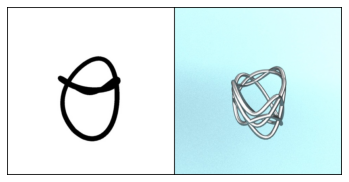

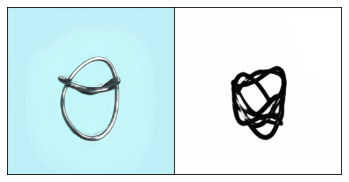

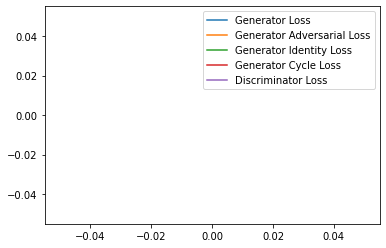

KeyboardInterrupt: ignored

In [20]:
from skimage import color
import numpy as np
from torchvision.utils import save_image




def train(save_model=False):
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    cur_step = 0
    generator_loss = []
    generator_adversarial_loss = []
    generator_identity_loss = [] 
    generator_cycle_loss= []
    discriminator_loss = [] 


    for epoch in range(n_epochs):
        for real_A, real_B in tqdm(dataloader):
            real_A = nn.functional.interpolate(real_A, size=target_shape)
            real_B = nn.functional.interpolate(real_B, size=target_shape)
            cur_batch_size = len(real_A)
            real_A = real_A.to(device)
            real_B = real_B.to(device)

            ### Update discriminator A ###
            disc_A_opt.zero_grad()
            with torch.no_grad():
                fake_A = gen_BA(real_B)
            disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
            disc_A_loss.backward(retain_graph=True)
            disc_A_opt.step() 

            ### Update discriminator B ###
            disc_B_opt.zero_grad() 
            with torch.no_grad():
                fake_B = gen_AB(real_A)
            disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
            disc_B_loss.backward(retain_graph=True) 
            disc_B_opt.step() 

            ### Update generator ###
            gen_opt.zero_grad()
            gen_loss, gen_adversarial_loss, gen_identity_loss, gen_cycle_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
            )
            gen_loss.backward()
            gen_opt.step()

            # Keep track of the average discriminator loss
            mean_discriminator_loss += disc_A_loss.item() / display_step
            discriminator_loss += [disc_A_loss.item()]

            # Keep track of the average generator loss
            mean_generator_loss += gen_loss.item() / display_step
            generator_loss += [gen_loss.item()]
            generator_adversarial_loss += [gen_adversarial_loss.item()]
            generator_identity_loss += [gen_identity_loss.item()]
            generator_cycle_loss += [gen_cycle_loss.item()] 

            ### Visualization code ###
            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss mean: {mean_generator_loss}, Discriminator loss mean: {mean_discriminator_loss}")
                print(f"\t\t Generator (U-Net) loss: {gen_loss.item()}, Discriminator loss: {disc_A_loss.item()}")
                show_tensor_images(torch.cat([real_A, real_B]), size=(dim_A, target_shape, target_shape))
                show_tensor_images(torch.cat([fake_B, fake_A]), size=(dim_B, target_shape, target_shape))
                mean_generator_loss = 0
                mean_discriminator_loss = 0
                x_axis = sorted([i * step_bins for i in range(len(generator_loss) // step_bins)] * step_bins)
                num_examples = (len(generator_loss) // step_bins) * step_bins
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_loss[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_adversarial_loss[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Adversarial Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_identity_loss[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Identity Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_cycle_loss[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Cycle Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(discriminator_loss[:num_examples]).view(-1, step_bins).mean(1),
                    label="Discriminator Loss"
                )
                
                plt.legend()
                plt.show()



            if cur_step % save_step == 0:
                if save_model:
                    torch.save({
                        'gen_AB': gen_AB.state_dict(),
                        'gen_BA': gen_BA.state_dict(),
                        'gen_opt': gen_opt.state_dict(),
                        'disc_A': disc_A.state_dict(),
                        'disc_A_opt': disc_A_opt.state_dict(),
                        'disc_B': disc_B.state_dict(),
                        'disc_B_opt': disc_B_opt.state_dict()
                    }, f"Models/lambda_5_lr_0.0002/cycleGAN_{cur_step}.pth")
                    
                    

                    
            cur_step += 1
train()

## CycleGAN testing

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

#import the test imagedataset
import torchvision
dataset = ImageDataset("Databases/sketch2rendering", transform=transform, mode='test')

Epoch 0: Step 0: Generator (U-Net) loss mean: 0.028928952217102052, Discriminator loss mean: 0.006060056090354919
		 Generator (U-Net) loss: 1.4464476108551025, Discriminator loss: 0.30300280451774597


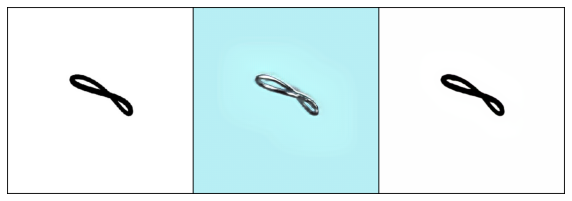

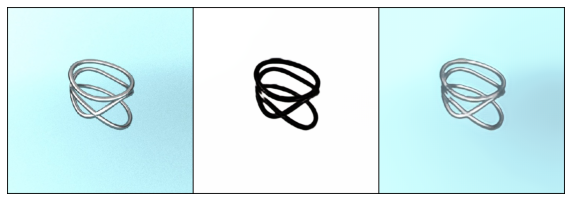

RuntimeError: ignored

In [22]:

from skimage import color
import numpy as np
from torchvision.utils import save_image
plt.rcParams["figure.figsize"] = (10, 10)


def test():
    #this testing function shows the whole cycle
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    cur_step = 0
    generator_loss = []
    discriminator_loss = [] 

    for epoch in range(n_epochs):
      for real_A, real_B in tqdm(dataloader):    
              real_A = nn.functional.interpolate(real_A, size=target_shape)
              real_B = nn.functional.interpolate(real_B, size=target_shape)
              cur_batch_size = len(real_A)
              real_A = real_A.to(device)
              real_B = real_B.to(device)

              with torch.no_grad():
                  fake_A = gen_BA(real_B)
                  fake_BAB = gen_AB(fake_A)
                  fake_B = gen_AB(real_A)
                  fake_ABA= gen_BA(fake_B)

              # Keep track of the average discriminator loss
              disc_A_loss = get_disc_loss(real_A, fake_A, disc_A, adv_criterion)
              disc_B_loss = get_disc_loss(real_B, fake_B, disc_B, adv_criterion)
              gen_loss, gen_adversarial_loss, gen_identity_loss, gen_cycle_loss, fake_A, fake_B = get_gen_loss(
                real_A, real_B, gen_AB, gen_BA, disc_A, disc_B, adv_criterion, recon_criterion, recon_criterion
              )
              mean_discriminator_loss += disc_A_loss.item() / display_step
              discriminator_loss += [disc_A_loss.item()]

              # Keep track of the average generator loss
              mean_generator_loss += gen_loss.item() / display_step
              generator_loss += [gen_loss.item()]

              print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss mean: {mean_generator_loss}, Discriminator loss mean: {mean_discriminator_loss}")
              print(f"\t\t Generator (U-Net) loss: {gen_loss.item()}, Discriminator loss: {disc_A_loss.item()}")
              show_tensor_images(torch.cat([real_A, fake_B, fake_ABA]), size=(dim_A, target_shape, target_shape))
              show_tensor_images(torch.cat([real_B,fake_A,fake_BAB]), size=(dim_B, target_shape, target_shape))

              cur_step += 1
                
            
test()

